In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
from Robot import Robot
from Models import BenchmarkBot, BetterBenchmarkBot, ManhattanBot, CautiousBot, FrontierBot, PotentialBot
from Maze import Maze
from maze_generator import prim, print_maze, save_maze, open_maze


# Definition

## Project Overview
In order for a robot to move around in its environment, it needs to do several things. It must:
- Track its own position.
- Translate sensor data into a map of its surroundings.
- Find a path to its objective.

Additionally, if the area is not already mapped out, the robot must explore the area and develop its own map. Each of these operations is critical for a robot to safely and effectively move through its environment. Thus, it is important to develop algorithms to accomplish these objectives. A good way to experiment and explore possible solutions to the problem of motion planning is by simulating a robot and its environment. This project is inspired by the Micromouse competitions, where a robot must explore and solve a maze.

## Problem Statement

The problem considered here is to implement an algorithm that will allow the simulated micromouse robot to solve the maze as quickly as possible. The robot gets two runs: one in which to explore the maze and determine an optimal route, and a second run in which to move from the starting location to the goal in the shortest number of steps. The score will be the number of steps required to reach the goal in the second run plus 1/30th of the number of steps used to explore the maze in the first run. The simulated robot should be able to solve any arbitrary maze presented to it.

## Metrics

The scoring metric for this project is defined as follows: _On each maze, the robot must complete two runs. In the first run, the robot is allowed to freely roam the maze to build a map of the maze. It must enter the goal room at some point during its exploration, but is free to continue exploring the maze after finding the goal. After entering the goal room, the robot may choose to end its exploration at any time. The robot is then moved back to the starting position and orientation for its second run. Its objective now is to go from the start position to the goal room in the fastest time possible. The robot’s score for the maze is equal to the number of time steps required to execute the second run, plus one thirtieth the number of time steps required to execute the first run. A maximum of one thousand time steps are allotted to complete both runs for a single maze._

This is a simple and objective measurement of the robot's performance. If the robot's behavior is at all random or stochastic, then it will be desirable to find an average score over many runs of the same maze to get a more accurate assessment. There are three test mazes provided, and these will be used to score the simulated micromouse robot. But it will also be possible, and desirable, to generate additional test mazes.

# Analysis

## Data Exploration and Visualization
### Test Mazes 1 - 3

Three test mazes are prvided with this project.  They are denoted 'test_maze_01', 'test_maze_02', 'test_maze_03'.  They are displayed below.  The goal area for each maze is the set of 4 squares at the center.  The starting position for the robot is the bottom left corner, at (0,0), facing up.

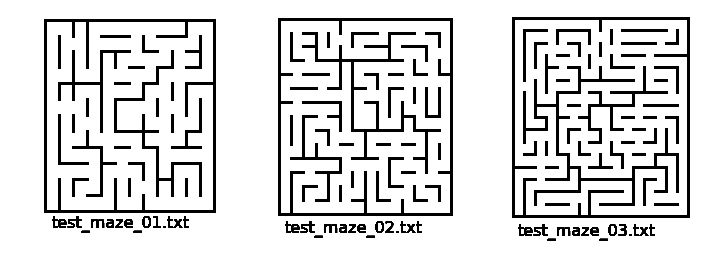

In [54]:
show_mazes(['test_maze_01.txt', 'test_maze_02.txt', 'test_maze_03.txt'])

The first maze is 12x12.  This maze is notable for requiring the robot to travel a long way around the outer areas of the maze.  In order to reach the goal, the robot will have to find it's way around the top, at (9,11), or around the bottom at (11,0).

The second maze is 16x16, the typical size of mazes in actual Micromouse competitions.  Similar to the first maze, the robot will have to find a long path around the outer areas.  But this maze also has a high number of dead ends.

The third maze is also 16x16.  This maze has many long corridors, dead ends, and broken up walls that could trap the robot into a closed loop.  

Since the robot can move up to three spaces in one step, this will have the effect of penalizing winding paths, and the robot will prefer straight lines.  

### Other Mazes
In addition to the supplied test mazes, we can generate our own to perform additional tests.  A simple baseline is an empty, 12x12 maze.  I also created a maze with many dead-ends and long passages, to see how different algorithms respond to this.

There are a number of algorithms for randomly generating mazes.  In the file maze_generator.py, I impletmented a version of Prim's minimum spanning tree algorithm to generate a random maze of any size.  I used this to generate a much larger maze of size 30x30 to see how different alogithms repsond.

These mazes are illustrated below.

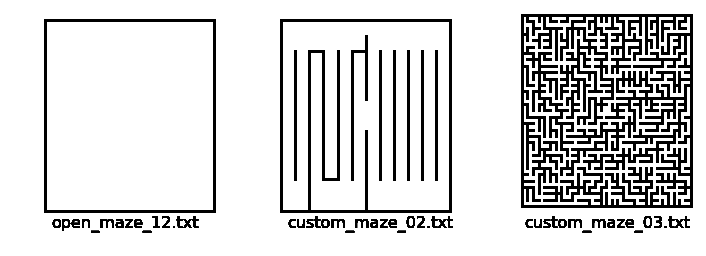

In [55]:
show_mazes(['open_maze_12.txt', 'custom_maze_02.txt', 'custom_maze_03.txt'])

## Algorithms and Techniques

An important task for this project is to find the shortest path between two places in the maze.  This can be thought of as finding the shortest path between two nodes of a graph.  And since every movement requires one step, we do not need to consider different movement costs.  So a simple breadth first search is sufficient to find the shortest path. This will be performed on the second run, once the maze has been mapped.

To map the maze, on the first run, at each step, the sensor data must be used to create a map.  Knowing the distance to the wall in each direction means the robot can determine all valid moves.  Additionally, if the wall is far enough away, the robot can determine something about the spaces ahead of it.  

In this project, I examine several different heuristics for exploring the maze.  The code for each one is contained in the Models.py file, and they are explained below in the Models and Refinement section below.


## Benchmark

The benchmark for this model will be a robot designed to randomly choose a valid move at every step.  The number of steps it takes for a completely random walk to reach the goal should serve as a bare minimum standard of performance. If a robot cannot beat a random walk through the maze, then the algorithm is very poor indeed. The goal will be to minimize the score calculated from the length of the two runs through the maze. Although the length of the second run is most heavily weighted by the scoring metric, it is the first run that needs to be most heavily optimized. Therefore, a better benchmark is to randomly explore the map on the first run, and then have the robot follow the shortest available path. Once the maze is mapped out, there is one optimal path length and that will be simple to find. The real challenge is to find a way to most efficiently explore the maze.

# Methodology

## Data Preprocessing

For this project, there is no need to preprocess any data.  The input data consists of test mazes, which are text files, containing a series of numbers.  Each number represents a square in the maze, and is a 4-bit binary number, representing whether there is a wall bordering the square on the left, bottom, right or top.

## Implementations

To implement a simulated robot capable of solving a maze, I start with a base python class called Robot.  This base class contains the methods and attributes that are required of the robot, regardless of the particular solving algorithm.  The full code is contained in the file Robot.py, and I summarize the methods and attributes as follows:
### Attributes
- `left_turn`, `right_turn` : These two dictionaries map one heading to another, to make it easier to execute turning movements.  For example, `right_turn['up'] = 'right'`, that is, when the current heading is up, turning to the right will change the heading to 'right'.
- `dir_move` : This dictionary maps a string representing the heading to an ordered pair of x,y coordinates.  For example, 'up' is mapped to [0, 1].
- `location` : a tuple containing the current location of the robot, initialized to `(0,0)`.
- `heading` : a string descirbing the current heading of the robot, initialized to `'up'`.
- `maze_map` : a dictionary that will contain entries for each square of the maze, and a corresponding set of other accessible squares.  Initally empty, at each step, it will be updated based on sensor input and location.
- `visited` : a Counter object to keep track of how many times each space has been visited.
- `goal_bounds` : the location of the goal area, based on the maze_dim.
- `explore` : a boolean flag to denote when the robot is on the first, exploring run of the maze.
- `path` : A list containing the squares on the path to a desired location.  Initialized to an empty list.

### Methods
- `__init__` : Takes `maze_dim` as an argument, and initializes the attributes above.
- `make_connection(self, square_1, square_2)` : alters self.maze_map to reflect that the robot can move from `square_1` to `square_2` and vice versa.
- `look_around(self, sensors)` : takes sensor input data, and uses it to update `self.maze_map`.  This will connect squares not only to the robot's current location, but it will also "look down the hall".  That is, if the wall ahead is a distance 6 away, even though it can only move 3 squares, the robot will remember that the square 5 spaces away can be reached from the squares 2,3 and 4 spaces away.
- `calc_move(self, target)` : determines the correct rotation and distance command to reach the square `target`, taken as an x,y coordinate pair.
- `at_goal(self)`: returns true if the robot is in the goal area.
- `found_goal(self)`: returns true if the robot has ever visited the goal area.
- `path_move(self)`: move the robot to the next square in the list self.path.
- `gen_path(self, target=None)`: Uses a breadth first search to find the shortest path to target from the current location.  If no target is given, a path is found to the goal area.  Returns a list of x,y coordinates of each square along the path.
- `run_maze(self, mazefile, verbose=True, showplot=True)`: Modified version of the tester.py file.  Tests the robot on the given maze file.  Verbose and showplot flags provide detail of the run.  Returns a calculated score.
- `test(self, trials=10, maze_list=None)`: Runs a number of test trials over a list of maze files and prints out average scores for each maze.

Critically, the base Robot class is lacking the `next_move(self, sensors)` function.  This function contains the actual algorithm to take sensor data and decide where to move, and is implemented in several child classes which will be described in detail below.  I chose to consoldiate these common attributes and methods in a parent class to avoid duplication of code, and make it easier to experiement with several different algorithms.  All that is necessary is to define a child class, implement the `next_move` function, and all the helper, visualization and testing functions can be re-used.

## Models and Refinement
The code for these different implementations is contained in the Models.py file.  Each one is discussed in turn, focusing on the exploration algorithm.

#### BenchmarkBot
My first idea for a benchmark was a completely random robot.  This class implements only the `next_move` function.  It will use the sensors to build a map of the maze, then randomly choose a space within range and move to it.  When it reaches the goal on the first run it will reset.  On the second run, it will do the same thing and move randomly.  In practice, I found this to not be a very good benchmark.  This bot will almost never complete the second run for lack of time.

#### BetterBenchmarkBot
This is an improvement over the BenchmarkBot.  It still explore the maze randomly, but on the second run, it will use a breadth first search to find the best path to the goal.  So it has a separate `explore_move` function to randomly pick a valid move, but after the `self.explore` flag is set to false, it will follow the shortest path, given its known map.  This will often allow it to complete a test maze in the alotted time.  Since finding the shortest path through a known graph is a simple and solved problem, using this as a benchmark focuses our attention on the exploration process.  This is where we will look to make improvements.

#### CautiousBot
The mapping and localization functionality is all implemented by the basic Robot class.  What is left is to decide where to explore.  My first idea for an exploring algorithm was a simple heuristic: move only one space at a time (hence, CautiousBot), to avoid having to backtrack, and randomly choose a neighboring space that has not been visited before.  If all neighboring spaces have been visited, choose one that has been visited the fewest amount of times.  Additionally, I included a parameter called `explore_frac`, which can force the bot to explore some fraction of the total maze squares before starting the second run.  I expected some tradeoff here.  By exploring more of the maze, the bot could discover a shorter route.  Based on the scoring metric, if more than 30 exploring steps are required to shorten the final path by one movement, this extra exploration will not improve the final score.

#### ManhattanBot
CautiousBot is biased towards exploring new spaces, but it makes no effort to move towards the goal area.  ManhattanBot instead chooses spaces to explore that get it closer to the goal.  In this implementation, the `explore_move` function makes a list of spaces it has seen but not visited before, chooses the closest one to the goal using the Manhattan distance metric, and follows the shortest path to that square.

#### FrontierBot
While ManhattanBot finds an unknown square closest to the goal, this bot finds an unknown square closest to itself and takes the shortest path there, prioritizing expanding the frontier of unexplored spaces.  This is the most computationally intensive algorithm examined, as it involves running the breadth first search algorithm many more times.  FrontierBot gives no thought to moving towards the goal, as ManhattanBot does, but instead seeks out unexplored spaces without caring about directions.  

#### PotentialBot
This was adapted from the algorithm described by Wyard-Scott and Meng[1].  Each square in the maze is assigned a potential value.  Initially, this is simply the square's distance from the goal.  If a dead-end is found, that square is assigned the max potential.  If there are multiple free directions, the square's potential is doubled when visited.  This prevents the bot from getting stuck at a local minimum, and penalizes backtracking through the same space many times.  At each step, the bot chooses to move in the direction of lowest potential.  This continues until the bot reaches the goal.  

# Results
## Model Evaluation and Validation
### Performance Summary
The table below summarizes the evaluated performance of each bot in each maze described above.

In [56]:
table

,test_maze_01.txt,test_maze_02.txt,test_maze_03.txt,open_maze_12.txt,custom_maze_02.txt,custom_maze_03.txt
BenchmarkBot,988.076667,1031.983333,1033.623333,52.016667,248.876667,1034.520000
BetterBenchmarkBot,535.263333,837.766667,937.536667,5.863333,16.736667,934.490000
ManhattanBot,35.400000,40.800000,33.900000,4.266667,13.700000,1035.366667
CautiousBot,23.763333,31.913333,37.406667,5.490000,12.586667,835.996667
FrontierBot,19.300000,30.333333,31.933333,4.666667,13.100000,48.633333
PotentialBot,21.933333,30.266667,28.900000,4.166667,10.133333,27.166667
Shortest Path,17.000000,22.000000,25.000000,4.000000,8.000000,19.000000


The totally random benchmark was unable to solve most mazes.  But the BetterBenchmark was able to finish all except the largest, so we can better compare it to our different bots.  Each of our agents were able to solve the mazes more quickly than the benchmark, but some performed better than others.

## Justification
#### ManhattanBot 
ManhattanBot has the worst performance out of our agents.  Basing our movements on the distance from the goal means this agent is biased towards exploring spaces in the center.  But for many of these mazes, the only way to reach the goal requires exploring the edge areas more.  This is illustrated well by its performance on test_maze_02.  The blue line is the final path that it found, and the red squares indicate explored spaces.  The darker the red, the more times the bot visited that space.


40.8

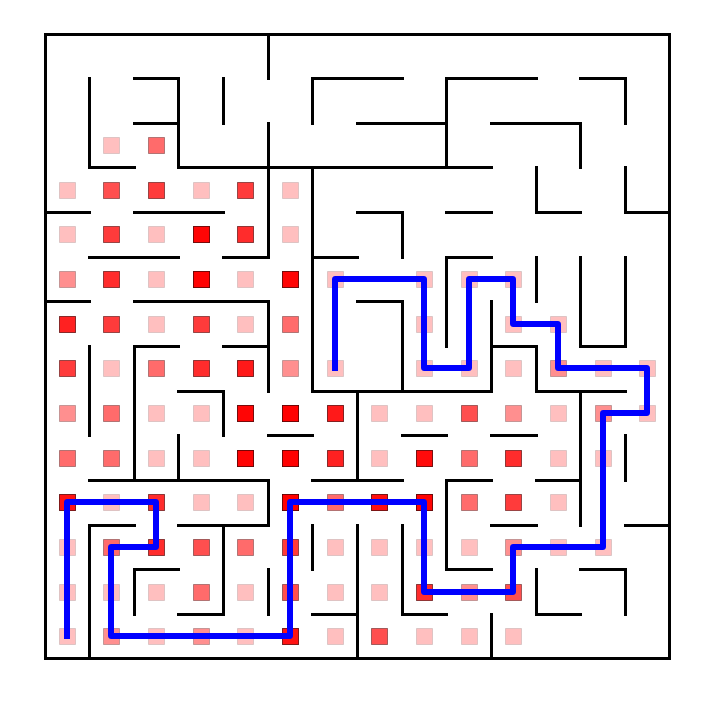

In [57]:
ManhattanBot(12).run_maze('test_maze_02.txt', verbose=False)

By exploring so often in the center, ManhattanBot was forced to backtrack and waste time during its first run.

#### CautiousBot #### 
CautiousBot shows some improvement.  The randomness in its choices does not bias it to explore one region, and by moving only one space at a time, it looks around all areas.  While this makes it slower, it is less likely to backtrack because it missed a square.  However, being random, this bot can get unlucky, and have to explore nearly the entire maze before finding the goal.  The `explore_frac` parameter turns out to not be very useful.  Below, I plot the average score over ten trial runs of `test_maze_01`, varying `explore_frac` from zero to one.  There is no real improvement in the score with a larger explore factor. And in fact, the performance suffers as `explore_frac` approaches 1, as it is diffifcult to randomly visit every last square.

It simply takes too many exploring steps to reduce the number of steps needed in the second run.

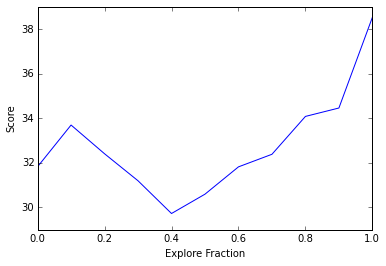

In [58]:
ef = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
scores = []
for frac in ef:
    score = sum([CautiousBot(12, explore_frac=frac).run_maze('test_maze_02.txt', 
                                                                     verbose=False, showplot=False) for i in range(10)])/10
    scores.append(score)      
plt.plot(ef, scores)
plt.xlabel('Explore Fraction')
plt.ylabel('Score')

#### FrontierBot ####
FrontierBot performs quite well.  This simulation is noticably slower to run, due to the repeated calls to `gen_path()` to determine short paths to unexplored spaces.  In a real robot, whether this is a problem or not would depend on the hardware available.  FrontierBot performed especially well on test_maze_01.  It did not find the exact shortest path, but it spent very little time exploring and found the goal quickly enough to make up for this.

FrontierBot also performed relatively poorly on custom_maze_02, showing that it spend too much time exploring long dead ends.  This is likely because it simply moves toward nearby unexplored areas and does not think of moving toward the goal at all.  But even this very simple heuristic performs better than random exploration, or only seeking the goal, like ManhattanBot.

Starting run 0.
reset recieved.  Robot actually at  [5, 6]
Ending first run. Starting next run.
Starting run 1.
Goal found; run 1 completed!
Task complete! Score: 19.300
First run: 39, second run: 18


19.3

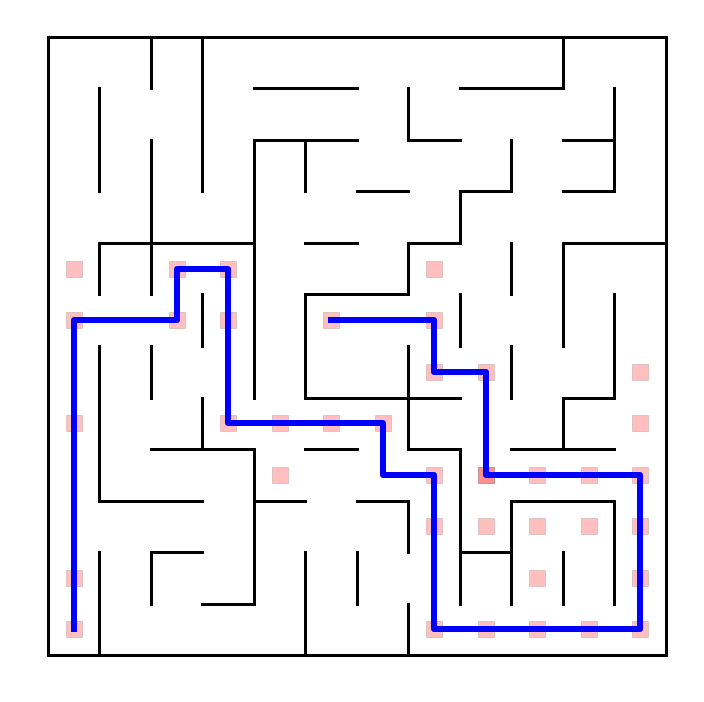

In [59]:
FrontierBot(16).run_maze('test_maze_01.txt')

#### PotentialBot
While FrontierBot performed well, its performance suffers when attempting larger maps, like custom_maze_03.  PotentialBot gave the best performance on every maze.  This algorithm combines two important ideas.  First, the initial potential biases the bot to seek the center, where the goal is.  Second, by updating the potential as the bot explores, and marking dead ends as high potential, the bot explores around obstacles and avoids backtracking too much.

Even the very large maze, 'custom_maze_03', with its many dead ends, does not pose a challenge.  PotentialBot significnatly outscored all other bots on this maze.  

Starting run 0.
reset recieved.  Robot actually at  [14, 15]
Ending first run. Starting next run.
Starting run 1.
Goal found; run 1 completed!
Task complete! Score: 27.167
First run: 245, second run: 19


27.166666666666664

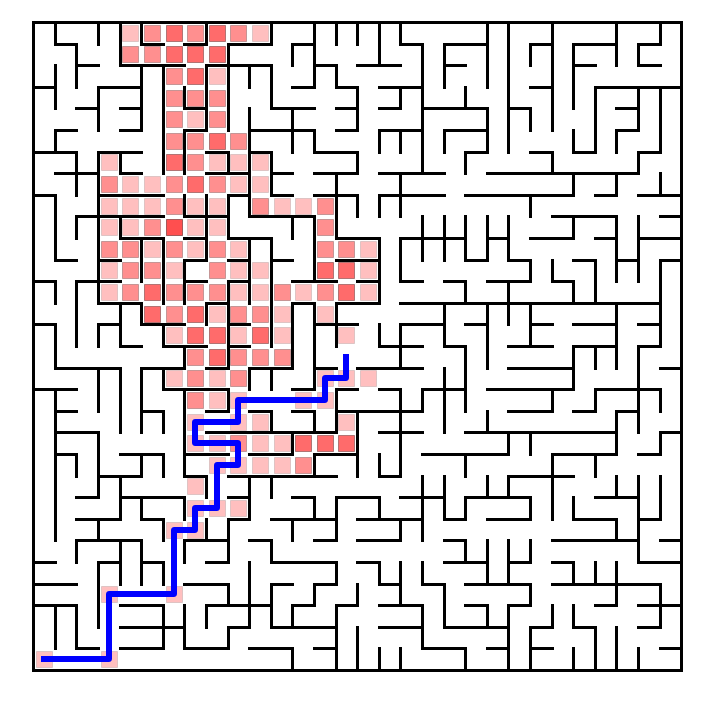

In [60]:
PotentialBot(30).run_maze('custom_maze_03.txt')

# Conclusion

In this project, I explored the problem of Simultaneous Localization and Mapping by considering a robot navigating a maze.  Starting with a randomly exploring benchmark, I created simulated robots to explore and solve a series of mazes.  Even simple exploration algorithms are able to improve over the random benchmark.  Of the models examined here, PotentialBot performed the best.  This algorithm combined goal seeking and avoidance of dead ends and backtracking.  

## Reflection and Visualization

There is something I found particularly interesting about PotentialBot's solution to test_maze_03.  The path it takes on its second run brings it through the top left corner, passing through spaces (0,15) and (3,15).  

Starting run 0.
reset recieved.  Robot actually at  [8, 8]
Ending first run. Starting next run.
Starting run 1.
Goal found; run 1 completed!
Task complete! Score: 28.900
First run: 117, second run: 25


28.9

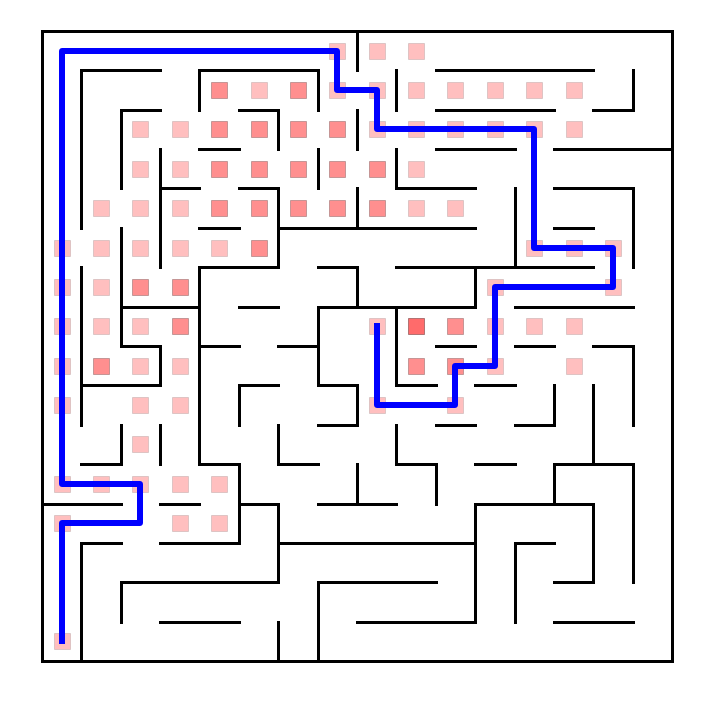

In [61]:
PotentialBot(16).run_maze('test_maze_03.txt')

But it never visited these spaces on the exploring run!  Because it 'saw' the spaces from (0,10) and again from (7,15), the map it built knew there was a path there it could take.  This is a very good result because it shows that the robot can map areas of the maze without having to actually exlpore them, allowing it to keep its first run as short as possible. 

This behavior is due to how the Robots build the map from sensor inputs, and is not unique to PotentialBot.  But the bots that prioritize exploration like FrontierBot, or those that are prone to backtracking, like ManhattanBot, are unlikely to take advantage of it.  

#### custom_maze_02
This custom maze was meant to be a simple test of how well the robots deal with long, dead-end corridors.  FrontierBot had particular trouble with this maze, having to backtrack down long corridors, and exploring in unecessary directions.

Starting run 0.
reset recieved.  Robot actually at  [5, 6]
Ending first run. Starting next run.
Starting run 1.
Goal found; run 1 completed!
Task complete! Score: 13.100
First run: 33, second run: 12


13.1

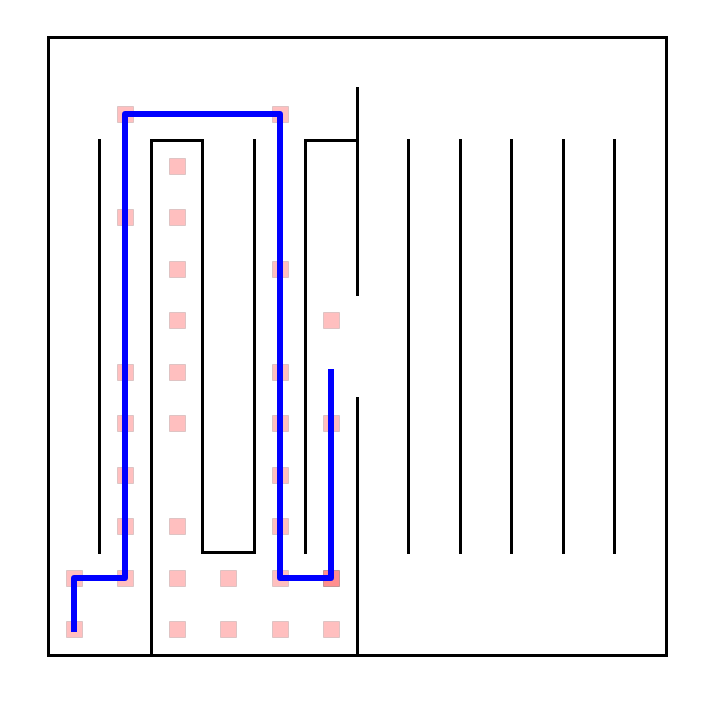

In [50]:
FrontierBot(30).run_maze('custom_maze_02.txt')

PotentialBot was also fooled into exploring one of these dead ends, but came up with a final pathway taking advantage of spaces it had seen, but not actually visited.  And the initial potential prevented it from exploring in the 'wrong' direction away from the goal, the way FrontierBot did.  

Starting run 0.
reset recieved.  Robot actually at  [6, 6]
Ending first run. Starting next run.
Starting run 1.
Goal found; run 1 completed!
Task complete! Score: 10.133
First run: 34, second run: 9


10.133333333333333

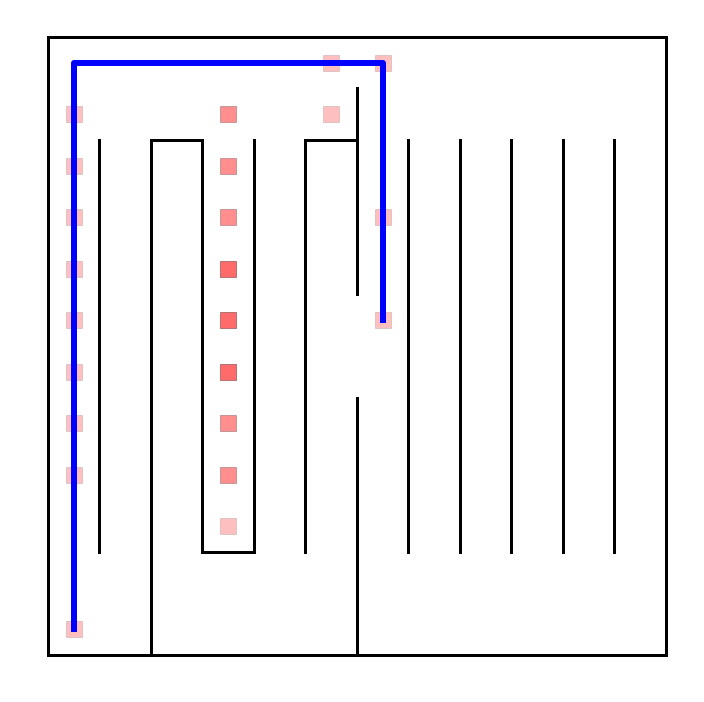

In [51]:
PotentialBot(30).run_maze('custom_maze_02.txt')

## Improvement

While these results are interesting and will be helpful when programming an actual robot, they are still simulations.  A physical robot moving in the real world will encounter futher challenges and opportunities.  An important difference is changing from a discrete environment, (where the robot occupies one space, can look and turn in 90 degree incrememnts, and can move exactly 1, 2 or 3 spaces) to a continuous environment where the robot can move, look and turn in any arbitrary direction.  

While a physical bot may still represent its map as a series of discrete squares connected to other squares and use graph theory algorithms to plan its path, now those discrete squares act as waypoints to move toward in a continuous, physical environment.  Converting discrete, grid-based movements to real locations will require additional processing.  But it also allows for diagonal movement, which can save time.  And by using sensors in all directions, instead of just discrete 90 degree increments, will give the bot more information about its surroundings.  It will require additional work to convert these sensors into a maze map, but it would allow the robot to map more areas of the maze without having to actually visit them, increasing efficiency.

And of course, moving through a real, 3D envionrment while avoiding obstacles and keeping track of its location is another set of challenges that these simulations do not address.  The simulated robots here do not have to worry about any level of uncertainty in their measurements.  In a real, physical environment, a robot's sensor may not always provide perfect, correct information.  And since the position here is tracked only by knowing the robot's start and the previous movement commands, errors can accumulate as the robot moves.  Additional algorithms such as the Kalman filter may be necessary to get a better position estimate in the presence of noise and uncertainty.

In [38]:
###Utility code to below to generate some data

In [10]:
B1 = BenchmarkBot(12)
B2 = BetterBenchmarkBot(12)
B3 = ManhattanBot(12)
B4 = CautiousBot(12, explore_frac=0)
B5 = FrontierBot(12)
B6 = PotentialBot(12)

In [18]:
allmaze = ['test_maze_01.txt', 'test_maze_02.txt', 'test_maze_03.txt',
           'open_maze_12.txt', 'custom_maze_02.txt', 'custom_maze_03.txt']
allbots = [B1, B2, B3, B4, B5, B6]

In [37]:
import pandas as pd
names = []
results = []
for B in allbots:
    score = B.test(trials=10, maze_list=allmaze)
    name = B.__class__
    names.append(str(name).split('.')[1].rstrip("'>"))
    results.append(score)
    
names.append('Shortest Path')
results.append(dict(zip(allmaze, [17,22,25,4,8,19])))
    
table = pd.DataFrame(index=names, data=results, columns=allmaze)

test_maze_01.txt: 988.08
test_maze_02.txt: 1031.98
test_maze_03.txt: 1033.62
open_maze_12.txt: 52.02
custom_maze_02.txt: 248.88
custom_maze_03.txt: 1034.52
test_maze_01.txt: 535.26
test_maze_02.txt: 837.77
test_maze_03.txt: 937.54
open_maze_12.txt: 5.86
custom_maze_02.txt: 16.74
custom_maze_03.txt: 934.49
test_maze_01.txt: 35.40
test_maze_02.txt: 40.80
test_maze_03.txt: 33.90
open_maze_12.txt: 4.27
custom_maze_02.txt: 13.70
custom_maze_03.txt: 1035.37
test_maze_01.txt: 23.76
test_maze_02.txt: 31.91
test_maze_03.txt: 37.41
open_maze_12.txt: 5.49
custom_maze_02.txt: 12.59
custom_maze_03.txt: 836.00
test_maze_01.txt: 19.30
test_maze_02.txt: 30.33
test_maze_03.txt: 31.93
open_maze_12.txt: 4.67
custom_maze_02.txt: 13.10
custom_maze_03.txt: 48.63
test_maze_01.txt: 21.93
test_maze_02.txt: 30.27
test_maze_03.txt: 28.90
open_maze_12.txt: 4.17
custom_maze_02.txt: 10.13
custom_maze_03.txt: 27.17


In [53]:
def show_mazes(maze_list):
    ML = [Maze(l) for l in maze_list]
    w = 12
    h = 12 / len(ML)
    fig, ax = plt.subplots(1, len(ML), figsize=(w,h))
    for i,M in enumerate(ML):
        for x in range(M.dim):
            for y in range(M.dim):
                ax[i].axis('off')
                ax[i].text(0, M.dim*(-1/8), maze_list[i], fontsize=16)
                #ax[i].title()
                if not M.is_permissible([x,y], 'up'):
                    ax[i].plot([x-0.5, x+0.5], [y+0.5, y+0.5], 'k-', linewidth=3)
                if not M.is_permissible([x,y], 'down'):
                    ax[i].plot([x-0.5, x+0.5], [y-0.5, y-0.5], 'k-', linewidth=3)
                if not M.is_permissible([x,y], 'right'):
                    ax[i].plot([x+0.5, x+0.5], [y-0.5, y+0.5], 'k-', linewidth=3)
                if not M.is_permissible([x,y], 'left'):
                    ax[i].plot([x-0.5, x-0.5], [y-0.5, y+0.5], 'k-', linewidth=3)

In [136]:
graph = {(i,j): set() for i in range(12) for j in range(12)}
size = 12
for i in range(12):
    for j in range(12):
        if (i,j) == (5,0):
            neigh = [(i, j-1), (i, j+1)]
        elif j not in [0,1,11,10]:
            neigh = [(i, j-1), (i, j+1)]
        else:
            neigh = [(i+1, j), (i-1, j), (i, j-1), (i, j+1)]
        for n in neigh:
            if n[0] in range(size) and n[1] in range(size):
                graph[(i,j)].add(n)
                graph[n].add((i,j))

lo, hi = size//2 - 1, size // 2  
goal_sq = [(lo,lo), (lo,hi), (hi,lo), (hi,hi)]
for i in range(4):
    for g in goal_sq[:i] + goal_sq[i+1:]:
        graph[goal_sq[i]].add(g)
        
for p1, p2 in [[(5,0), (6,0)], [(5,1), (6,1)], [(5,10),(5,9)], [(1,0),(2,0)], [(1,1),(2,1)],
              [(3,1),(3,2)],[(2,10),(2,9)], [(5,10), (6,10)]]:
    graph[p1].remove(p2)
    graph[p2].remove(p1)

Starting run 0.
reset recieved.  Robot actually at  [6, 6]
Ending first run. Starting next run.
Starting run 1.
Goal found; run 1 completed!
Task complete! Score: 10.133
First run: 34, second run: 9


10.133333333333333

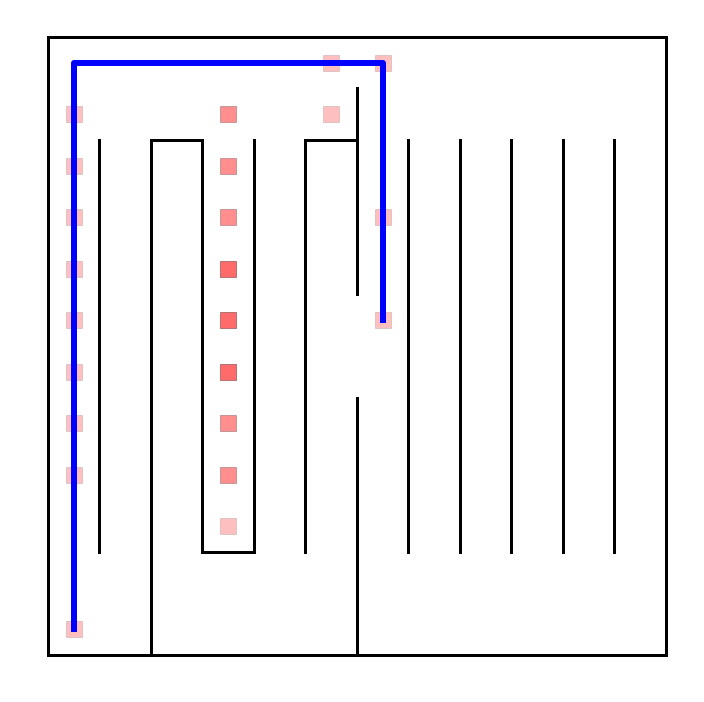

In [46]:
PotentialBot(30).run_maze('custom_maze_02.txt')

Starting run 0.
reset recieved.  Robot actually at  [4, 8]
Ending first run. Starting next run.
Starting run 1.
Goal found; run 1 completed!
Task complete! Score: 13.400
First run: 162, second run: 8


13.4

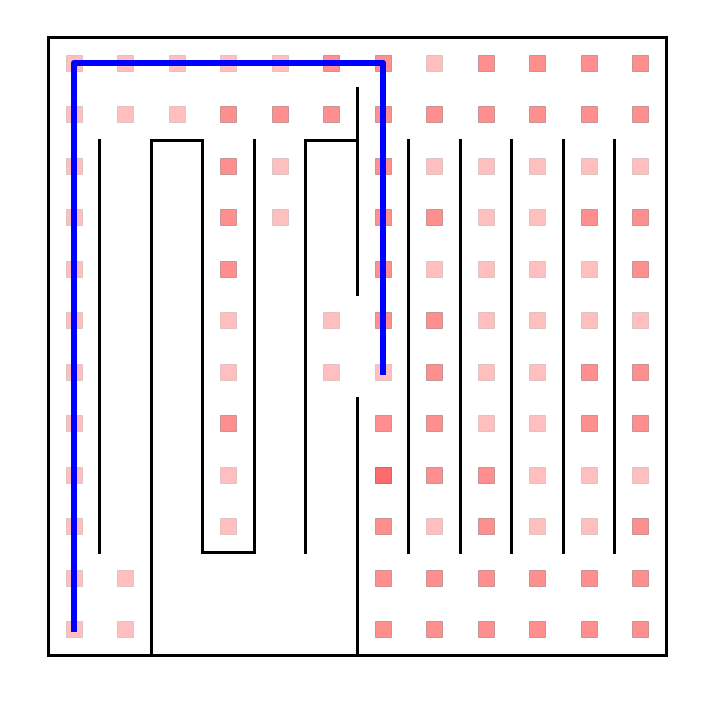

In [62]:
CautiousBot(12,explore_frac=0.75).run_maze('custom_maze_02.txt')